In [63]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Set plot style
sns.set_style("whitegrid")

In [64]:
# Load the raw JSON data from the file
try:
    with open('user-wallet-transactions.json', 'r') as file:
        raw_data = json.load(file)
    print(f"Successfully loaded {len(raw_data)} transaction records.")
except FileNotFoundError:
    print("Error: 'user-wallet-transactions.json' not found. Please ensure the file is in the correct directory.")
    raw_data = [] # Assign empty list to prevent errors in subsequent cells

# Displaying a sample record to understand its structure
if raw_data:
    print("\nSample Record:")
    print(json.dumps(raw_data[0], indent=2))

Successfully loaded 100000 transaction records.

Sample Record:
{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },
  "updatedAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  }
}


In [47]:
if raw_data:
    wallet_stats = defaultdict(lambda: defaultdict(float))
    wallet_timestamps = defaultdict(list)

    # Loop through each transaction to extract features
    for tx in raw_data:
        wallet = tx['userWallet']
        action = tx['action'].lower()
        timestamp = tx.get('timestamp')

        try:
            amount = float(tx['actionData']['amount']) / 1e6
            price = float(tx['actionData'].get('assetPriceUSD', 1.0))
            usd_value = amount * price
        except (ValueError, KeyError):
            continue

        # --- Accumulate Stats ---
        wallet_stats[wallet]['total_tx'] += 1
        wallet_stats[wallet]['total_usd_all_actions'] += usd_value
        wallet_stats[wallet][f'num_{action}'] += 1
        wallet_stats[wallet][f'total_usd_{action}'] += usd_value

        if 'actions_set' not in wallet_stats[wallet]: wallet_stats[wallet]['actions_set'] = set()
        wallet_stats[wallet]['actions_set'].add(action)

        token = tx['actionData'].get('assetSymbol')
        if token:
            if 'token_set' not in wallet_stats[wallet]: wallet_stats[wallet]['token_set'] = set()
            wallet_stats[wallet]['token_set'].add(token)

        if timestamp:
            wallet_timestamps[wallet].append(timestamp)

    # --- Constructing the Final Features DataFrame ---
    features_list = []


    all_timestamps = [ts for times in wallet_timestamps.values() for ts in times]
    latest_timestamp = max(all_timestamps) if all_timestamps else 0

    for wallet, stats in wallet_stats.items():
        # --- Basic & Behavioral Ratio Features ---
        total_tx = stats['total_tx']
        num_borrows = stats.get('num_borrow', 0)
        num_repays = stats.get('num_repay', 0)
        repay_borrow_ratio_count = num_repays / num_borrows if num_borrows > 0 else 1

        # --- Loan Health & Risk Features ---
        total_deposit_usd = stats.get('total_usd_deposit', 0)
        total_borrow_usd = stats.get('total_usd_borrow', 0)
        leverage_ratio = total_borrow_usd / (total_deposit_usd + 1e-6)
        net_protocol_worth = total_deposit_usd - total_borrow_usd

        total_repay_usd = stats.get('total_usd_repay', 0)
        repay_borrow_ratio_value = total_repay_usd / (total_borrow_usd + 1e-6)

        # --- Risk Indicators ---
        num_liquidations = stats.get('num_liquidationcall', 0)
        liquidation_ratio = num_liquidations / total_tx if total_tx > 0 else 0

        # --- Time-Based & Activity Features ---
        timestamps = sorted(wallet_timestamps.get(wallet, [0]))
        first_tx_ts = timestamps[0] if timestamps else 0
        last_tx_ts = timestamps[-1] if timestamps else 0

        active_days = (last_tx_ts - first_tx_ts) / 86400 if (last_tx_ts - first_tx_ts) > 0 else 0
        time_since_last_tx_days = (latest_timestamp - last_tx_ts) / 86400 if last_tx_ts > 0 else float('inf')

        avg_time_between_tx_days = active_days / total_tx if total_tx > 1 else 0

        # --- Append all features for the wallet ---
        features_list.append({
            'wallet': wallet,
            'total_tx': total_tx,
            'total_usd_all_actions': stats['total_usd_all_actions'],
            'avg_usd_per_tx': stats['total_usd_all_actions'] / total_tx if total_tx > 0 else 0,

            'repay_borrow_ratio_count': repay_borrow_ratio_count,
            'repay_borrow_ratio_value': repay_borrow_ratio_value,

            'num_liquidations': num_liquidations,
            'liquidation_ratio': liquidation_ratio,
            'leverage_ratio': leverage_ratio,
            'net_protocol_worth': net_protocol_worth,

            'active_days': active_days,
            'time_since_last_tx_days': time_since_last_tx_days,
            'avg_time_between_tx_days': avg_time_between_tx_days,
            'num_token_types': len(stats.get('token_set', [])),
            'num_action_types': len(stats.get('actions_set', []))
        })

    df_features = pd.DataFrame(features_list).set_index('wallet')

    print("Enhanced feature engineering complete. DataFrame shape:", df_features.shape)
    print("\nSample of new engineered features:")
    df_features.head()

Enhanced feature engineering complete. DataFrame shape: (3497, 14)

Sample of new engineered features:


In [49]:
if 'df_features' in locals() and not df_features.empty:
    # --- CORRECTED: Selecting the new, updated feature names for clustering ---
    feature_cols = [
        'repay_borrow_ratio_count', # Using the count-based ratio for clustering
        'liquidation_ratio',
        'active_days',
        'total_usd_all_actions',    # Using the new total USD column
        'avg_time_between_tx_days'  # Using avg time instead of tx_per_day
    ]

    # Preparing the data for clustering (fill NaNs and handle potential Infs)
    X = df_features[feature_cols].copy()
    X.replace([np.inf, -np.inf], 0, inplace=True) # Replacing any infinite values
    X.fillna(0, inplace=True)

    # Scaling features for the model
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # --- K-Means Clustering ---
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df_features['cluster'] = kmeans.fit_predict(X_scaled)

    print("Wallets have been clustered into 5 groups.")

    # --- Score Generation from Clusters ---

    cluster_ranks = (df_features.groupby('cluster')['repay_borrow_ratio_count'].mean() -
                     df_features.groupby('cluster')['liquidation_ratio'].mean() * 2) # Penalize liquidations


    score_mapping = cluster_ranks.rank(method='dense').astype(int) - 1

    # Maping cluster number to a score from 0 to 1000
    df_features['credit_score'] = df_features['cluster'].map(score_mapping) * 250

    print("\nCredit scores have been assigned based on cluster ranks.")
    print("\nScore mapping from cluster to score:")
    print(score_mapping * 250)

    # Displaying the head of the DataFrame with the new 'credit_score' column
    df_features[['total_tx', 'repay_borrow_ratio_count', 'num_liquidations', 'cluster', 'credit_score']].head()

Wallets have been clustered into 5 groups.

Credit scores have been assigned based on cluster ranks.

Score mapping from cluster to score:
cluster
0       0
1    1000
2     500
3     250
4     750
dtype: int64


/tmp/ipython-input-55-3362290604.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_features, x='score_bin', order=labels, palette="viridis")


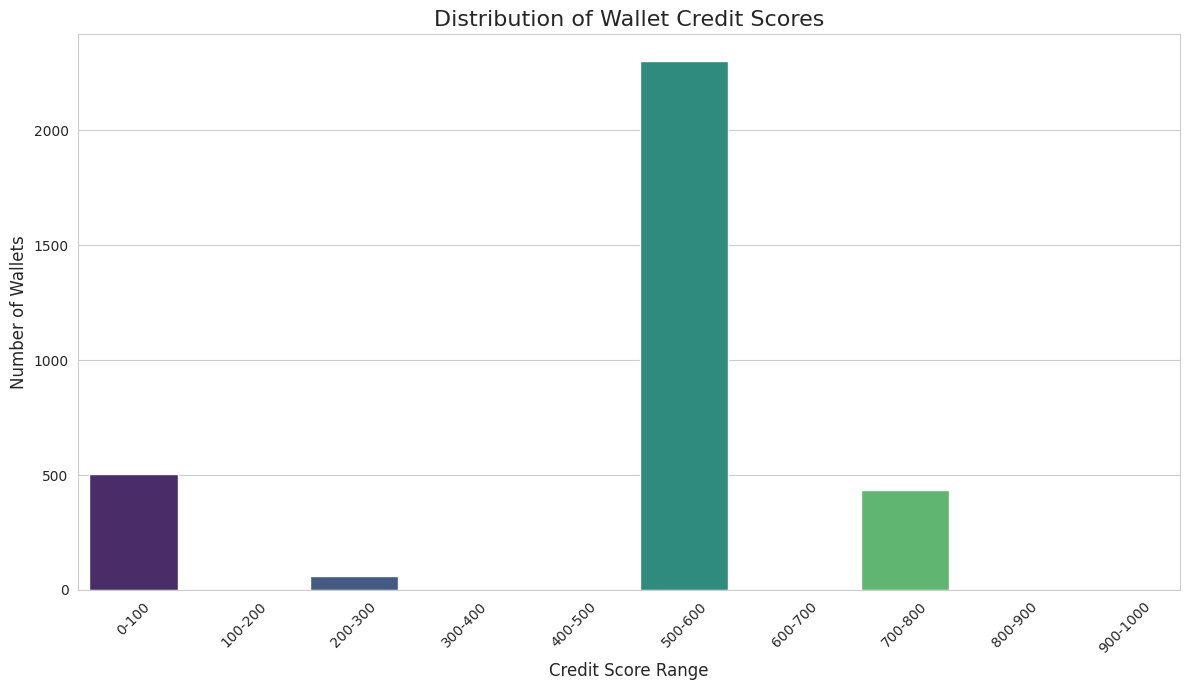


--- Average Behavior by Credit Score Range ---
           repay_borrow_ratio_count  num_liquidations  total_tx  active_days  \
score_bin                                                                      
0-100                          0.82              0.13     28.41        30.32   
200-300                        0.83              0.03      3.62        70.30   
500-600                        0.89              0.02      5.25         2.03   
700-800                        0.92              0.20    108.10        70.06   

           total_usd_all_actions  leverage_ratio  
score_bin                                         
0-100               9.248951e+17    7.864834e+17  
200-300             3.114134e+16    7.000000e-02  
500-600             1.054269e+17    1.380501e+21  
700-800             5.242843e+17    1.838524e+19  

--- Behavioral Insights ---

Characteristics of HIGH-SCORE Wallets (Score >= 750):
       repay_borrow_ratio_count  num_liquidations      total_tx  active_days  \
c

In [55]:
if 'df_features' in locals() and not df_features.empty:
    # Creating score bins for visualization
    bins = list(range(0, 1100, 100))
    labels = [f"{i}-{i+100}" for i in range(0, 1000, 100)]
    df_features['score_bin'] = pd.cut(df_features['credit_score'], bins=bins, labels=labels, right=False)

    # --- 1. Score Distribution Plot ---
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df_features, x='score_bin', order=labels, palette="viridis")
    plt.title("Distribution of Wallet Credit Scores", fontsize=16)
    plt.xlabel("Credit Score Range", fontsize=12)
    plt.ylabel("Number of Wallets", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 2. Behavior Analysis by Score Group (Corrected) ---

    behavior_cols = [
        'repay_borrow_ratio_count',
        'num_liquidations',
        'total_tx',
        'active_days',
        'total_usd_all_actions',
        'leverage_ratio'
    ]

    # Using observed=True for groupby to handle the categorical bins correctly
    grouped_behavior = df_features.groupby('score_bin', observed=True)[behavior_cols].mean()

    print("\n--- Average Behavior by Credit Score Range ---")
    print(grouped_behavior.round(2))

    # --- 3. Detail of  Insights for analysis.md ---
    high_score_wallets = df_features[df_features['credit_score'] >= 750]
    low_score_wallets = df_features[df_features['credit_score'] <= 250]

    print("\n--- Behavioral Insights ---")
    print("\nCharacteristics of HIGH-SCORE Wallets (Score >= 750):")
    print(high_score_wallets[behavior_cols].describe())

    print("\nCharacteristics of LOW-SCORE Wallets (Score <= 250):")
    print(low_score_wallets[behavior_cols].describe())

In [57]:
if 'df_features' in locals() and not df_features.empty:
    # --- CORRECTED: Selecting the final, correct columns for the output file ---
    output_columns = [
        'total_tx',
        'total_usd_all_actions', # Corrected name
        'repay_borrow_ratio_count', # Corrected name
        'num_liquidations',
        'active_days',
        'leverage_ratio', # Added new feature
        'credit_score'
    ]

    # Saving the cleaned DataFrame with the selected columns to a CSV file
    # We used the wallet index as a column in the final output
    df_features[output_columns].to_csv('wallet_credit_scores.csv', index_label='wallet')

    print("Final credit scores have been successfully saved to 'wallet_credit_scores.csv'.")
    print("\n--- Project Complete! ---")
    print("You now have a complete notebook and the final CSV output for your deliverables.")

Final credit scores have been successfully saved to 'wallet_credit_scores.csv'.

--- Project Complete! ---
You now have a complete notebook and the final CSV output for your deliverables.


In [58]:
df_features[output_columns].head()

,total_tx,total_usd_all_actions,repay_borrow_ratio_count,num_liquidations,active_days,leverage_ratio,credit_score
wallet,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1.0,1.987664e+03,1.000000,0.0,0.000000,0.000000,500
0x000000000051d07a4fb3bd10121a343d85818da6,1.0,2.856945e+14,1.000000,0.0,0.000000,0.000000,500
0x000000000096026fb41fc39f9875d164bd82e2dc,2.0,5.152311e+09,1.000000,0.0,7.574132,0.000000,500
0x0000000000e189dd664b9ab08a33c4839953852c,17.0,9.803600e+14,1.000000,0.0,129.327766,0.000000,1000
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399.0,3.797495e+17,0.266667,0.0,132.865903,0.291889,1000


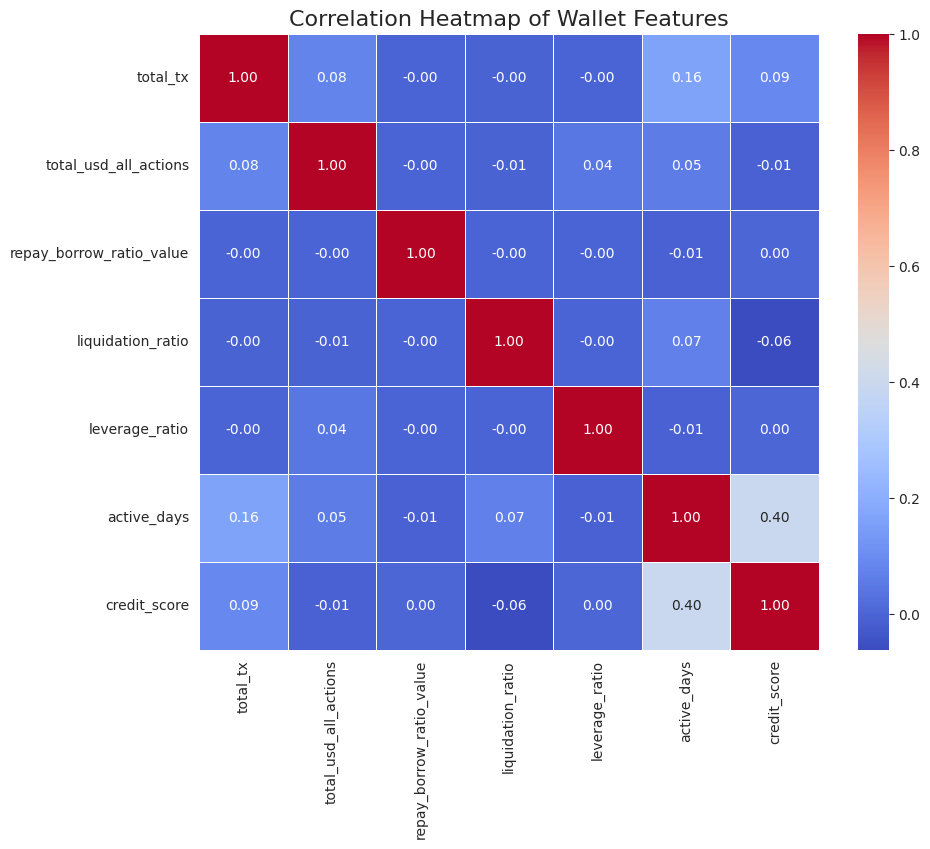

In [59]:
if 'df_features' in locals() and not df_features.empty:
    #  key numerical features for the heatmap
    heatmap_features = df_features[['total_tx', 'total_usd_all_actions', 'repay_borrow_ratio_value',
                                    'liquidation_ratio', 'leverage_ratio', 'active_days', 'credit_score']]

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Wallet Features', fontsize=16)
    plt.show()

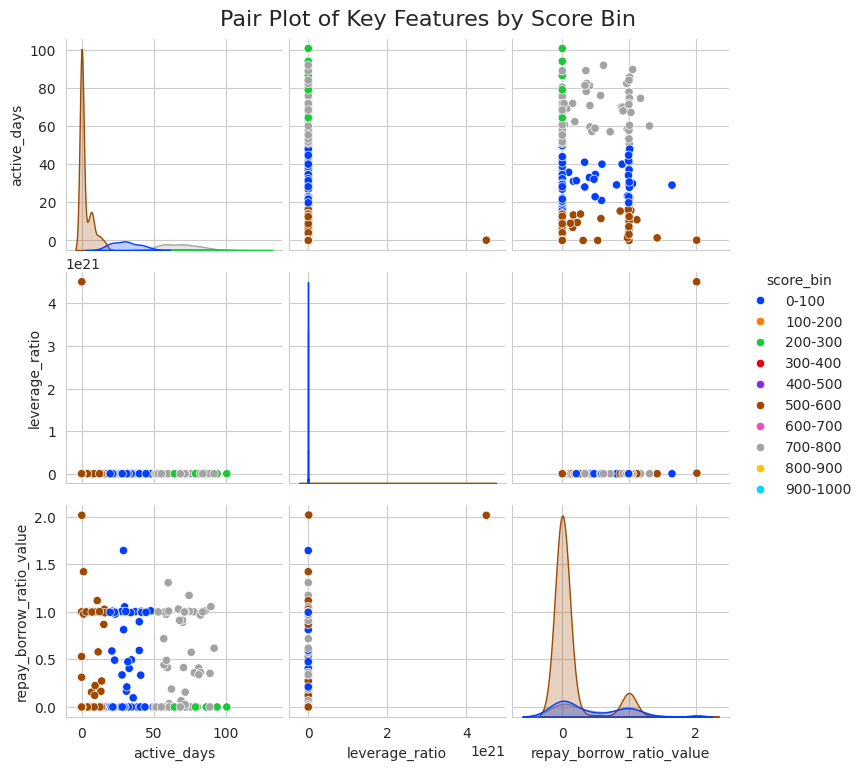

In [60]:
if 'df_features' in locals() and not df_features.empty:
    # Using a sample of the data for the pair plot to keep it from being too slow
    pairplot_sample = df_features.sample(n=min(500, len(df_features)), random_state=42)

    sns.pairplot(pairplot_sample, vars=['active_days', 'leverage_ratio', 'repay_borrow_ratio_value'],
                 hue='score_bin', palette='bright', diag_kind='kde')
    plt.suptitle('Pair Plot of Key Features by Score Bin', y=1.02, fontsize=16)
    plt.show()

/tmp/ipython-input-61-2446030535.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='score_bin', y='leverage_ratio', palette='pastel', showfliers=False) # Hide outliers for clarity
/tmp/ipython-input-61-2446030535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='score_bin', y='active_days', palette='pastel')


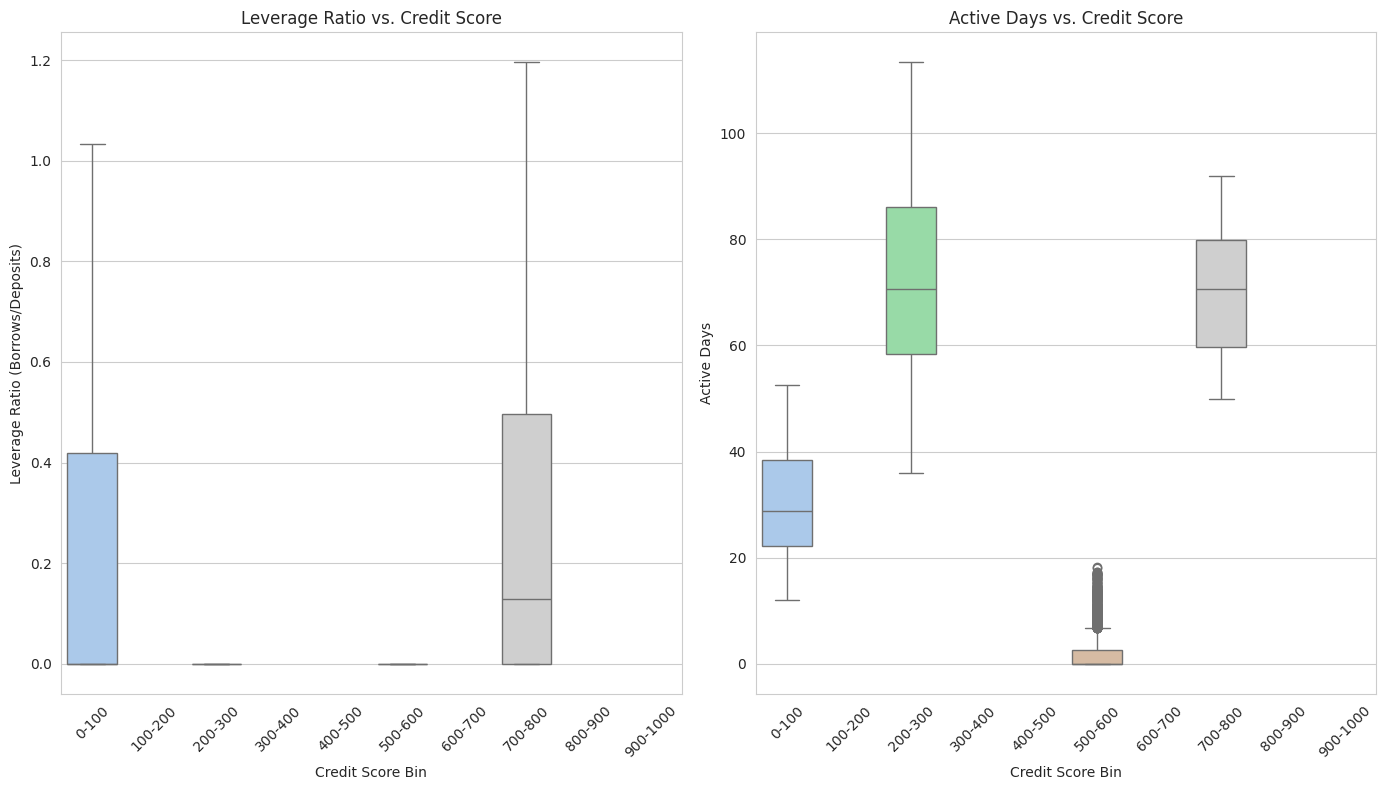

In [61]:
if 'df_features' in locals() and not df_features.empty:
    plt.figure(figsize=(14, 8))

    # Box plot for Leverage Ratio
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_features, x='score_bin', y='leverage_ratio', palette='pastel', showfliers=False) # Hide outliers for clarity
    plt.title('Leverage Ratio vs. Credit Score')
    plt.xlabel('Credit Score Bin')
    plt.ylabel('Leverage Ratio (Borrows/Deposits)')
    plt.xticks(rotation=45)

    # Box plot for Active Days
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_features, x='score_bin', y='active_days', palette='pastel')
    plt.title('Active Days vs. Credit Score')
    plt.xlabel('Credit Score Bin')
    plt.ylabel('Active Days')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

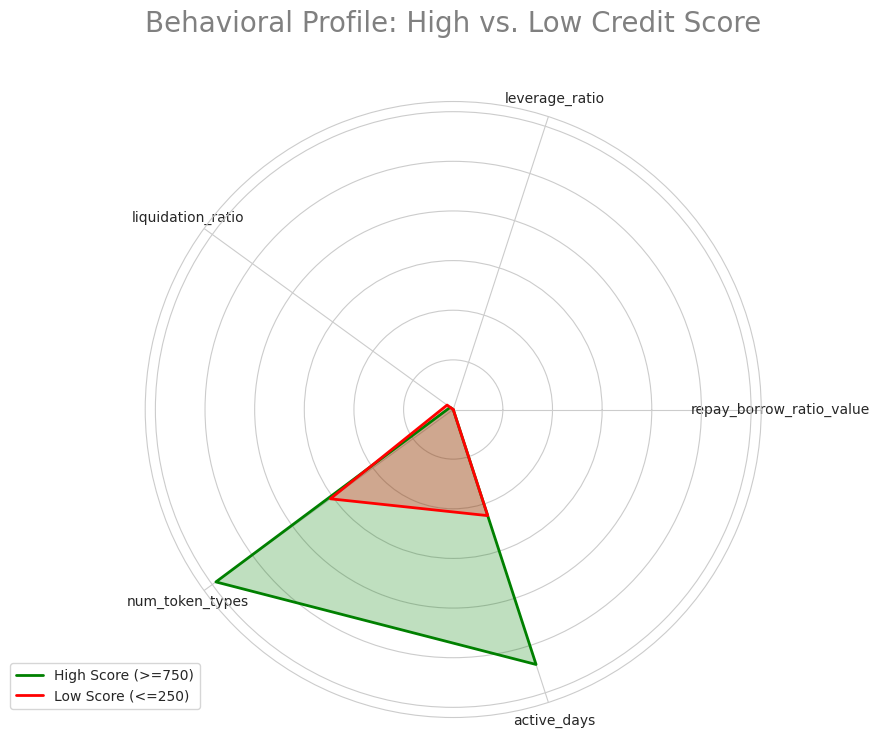

In [62]:
if 'df_features' in locals() and not df_features.empty:
    # Selecting features for the radar chart and normalize them
    radar_cols = ['repay_borrow_ratio_value', 'leverage_ratio', 'liquidation_ratio', 'num_token_types', 'active_days']

    # Normalizing data for radar chart (0 to 1)
    scaler_radar = MinMaxScaler()
    df_radar = df_features.copy()
    df_radar[radar_cols] = scaler_radar.fit_transform(df_radar[radar_cols])

    # Getting average profiles for high and low score groups
    high_score_profile = df_radar[df_radar['credit_score'] >= 750][radar_cols].mean().values
    low_score_profile = df_radar[df_radar['credit_score'] <= 250][radar_cols].mean().values

    # --- Plotting the Radar Chart ---
    labels = np.array(radar_cols)
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot High Score Profile
    high_score_values = np.concatenate((high_score_profile, [high_score_profile[0]]))
    ax.plot(angles, high_score_values, color='green', linewidth=2, linestyle='solid', label='High Score (>=750)')
    ax.fill(angles, high_score_values, 'green', alpha=0.25)

    # Plot Low Score Profile
    low_score_values = np.concatenate((low_score_profile, [low_score_profile[0]]))
    ax.plot(angles, low_score_values, color='red', linewidth=2, linestyle='solid', label='Low Score (<=250)')
    ax.fill(angles, low_score_values, 'red', alpha=0.25)

    # Formatting
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title('Behavioral Profile: High vs. Low Credit Score', size=20, color='gray', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()